```
---
title: Small molecules in ChEBI
tags: smallMolecules, ChEBI
lang: en
version: 0.1
date: 2023-06-06
---
```

In [1]:
import importlib
import json
import matplotlib.pyplot as plt
import networkx as nx
import os
import pandas
import rdflib
import rdflib.namespace
import sparqldataframe
from SPARQLWrapper import SPARQLWrapper, JSON
import sys

In [2]:
reactomeVersion = 83 # was 81
chebiVersion = 221 # was 219 # was 207
#endpointURL = "http://localhost:3030/reactome/query"
#endpointURL = "http://localhost:3030/chebi/query"
endpointURL = "http://localhost:3030/chebi/query"
rdfFormat = "turtle"

In [3]:
prefixes = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

PREFIX chebi: <http://purl.obolibrary.org/obo/chebi/>
PREFIX chebidb: <http://purl.obolibrary.org/obo/CHEBI_>
PREFIX chebirel: <http://purl.obolibrary.org/obo/CHEBI#>
PREFIX oboInOwl: <http://www.geneontology.org/formats/oboInOwl#>

PREFIX bp3: <http://www.biopax.org/release/biopax-level3.owl#>

# Homo_sapiens-20170221.owl
#PREFIX reactome: <http://www.reactome.org/biopax/59/48887#> 
#
# Homo_sapiens-20210608.owl
#PREFIX reactome: <http://www.reactome.org/biopax/77/48887#>
#
# Homo_sapiens-20220614.owl
#PREFIX reactome: <http://www.reactome.org/biopax/81/48887#>
#
# Homo_sapiens-20221130.owl
#PREFIX reactome: <http://www.reactome.org/biopax/83/48887#>

PREFIX reactome: <http://www.reactome.org/biopax/{}/48887#>
""".format(reactomeVersion)

# ChEBI version

In [5]:
query="""
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

SELECT ?ontology ?versionIRI (REPLACE(REPLACE(STR(?versionIRI), 'http://purl.obolibrary.org/obo/chebi/', ''), '/chebi.owl', '') AS ?versionNumber)
WHERE {
  ?ontology rdf:type owl:Ontology .
  ?ontology owl:versionIRI ?versionIRI .
}
"""

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

chebiVersion = int(results["results"]["bindings"][0]["versionNumber"]["value"])
print("ChEBI version: {}".format(chebiVersion))

ChEBI version: 221


# Relations applicable to molecules

In [27]:
query="""
SELECT DISTINCT ?rel
WHERE {
  
  ?molecule rdfs:subClassOf* chebidb:24431 . # chemical entity
  #?molecule rdfs:subClassOf* chebidb:23367 . # molecular entity

  ?molecule rdf:type owl:Class .
  ?molecule ?rel ?_ .
}
ORDER BY ?rel
"""

#df = sparqldataframe.query(endpointURL, prefixes+query)
#df

sparql = SPARQLWrapper(endpointURL)
sparql.setQuery(prefixes+query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
for result in results["results"]["bindings"]:
    print(result["rel"]["value"])


http://purl.obolibrary.org/obo/IAO_0000115
http://purl.obolibrary.org/obo/chebi/charge
http://purl.obolibrary.org/obo/chebi/formula
http://purl.obolibrary.org/obo/chebi/inchi
http://purl.obolibrary.org/obo/chebi/inchikey
http://purl.obolibrary.org/obo/chebi/mass
http://purl.obolibrary.org/obo/chebi/monoisotopicmass
http://purl.obolibrary.org/obo/chebi/smiles
http://www.geneontology.org/formats/oboInOwl#hasAlternativeId
http://www.geneontology.org/formats/oboInOwl#hasDbXref
http://www.geneontology.org/formats/oboInOwl#hasExactSynonym
http://www.geneontology.org/formats/oboInOwl#hasOBONamespace
http://www.geneontology.org/formats/oboInOwl#hasRelatedSynonym
http://www.geneontology.org/formats/oboInOwl#id
http://www.geneontology.org/formats/oboInOwl#inSubset
http://www.w3.org/1999/02/22-rdf-syntax-ns#type
http://www.w3.org/2000/01/rdf-schema#label
http://www.w3.org/2000/01/rdf-schema#subClassOf


# Number of chemical entities and subclasses

In [4]:
query="""
SELECT ?molecule ?moleculeName (COUNT(DISTINCT ?moleculeDescendant) AS ?nbDescendants)
WHERE {
  #VALUES ?molecule { chebidb:32736 }
  
  ?molecule rdfs:subClassOf? chebidb:24431 . # chemical entity
  #?molecule rdfs:subClassOf? chebidb:23367 . # molecular entity
  
  ?moleculeDescendant rdfs:subClassOf* ?molecule .
  ?moleculeDescendant rdf:type owl:Class .
  
  OPTIONAL { ?molecule rdfs:label ?moleculeName }
}
GROUP BY ?molecule ?moleculeName 
ORDER BY DESC(?nbDescendants)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

molecule        moleculeName  \
0  http://purl.obolibrary.org/obo/CHEBI_24431     chemical entity   
1  http://purl.obolibrary.org/obo/CHEBI_23367    molecular entity   
2  http://purl.obolibrary.org/obo/CHEBI_24433               group   
3  http://purl.obolibrary.org/obo/CHEBI_59999  chemical substance   
4  http://purl.obolibrary.org/obo/CHEBI_33250                atom   

  nbDescendants  
0        162910  
1        158703  
2          3060  
3          1318  
4           277

![ChEBI chemical entity branch](images/chebi_chemicalEntity_tree.png)

# Molecules by number of stars

In [8]:
query="""
SELECT ?subset (COUNT(DISTINCT ?molecule) AS ?nbMolecules)
WHERE {
  #VALUES ?molecule { chebidb:32736 }
  
  ?molecule rdfs:subClassOf* chebidb:24431 . # chemical entity
  #?molecule rdfs:subClassOf* chebidb:23367 . # molecular entity

  ?molecule rdf:type owl:Class .
  ?molecule oboInOwl:inSubset ?subset .
}
GROUP BY ?subset 
#ORDER BY DESC(?nbMolecules)
ORDER BY DESC(?subset)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df['nbMolecules'] = pandas.to_numeric(df['nbMolecules'])
df

subset  nbMolecules
0  http://purl.obolibrary.org/obo/chebi#3_STAR        59007
1  http://purl.obolibrary.org/obo/chebi#2_STAR       101005
2  http://purl.obolibrary.org/obo/chebi#1_STAR         2898

In [19]:
df['nbStars'] = df['subset'].apply(lambda x: x.replace("http://purl.obolibrary.org/obo/chebi#", ""))
#df
df[['nbStars', 'nbMolecules']]

nbStars  nbMolecules
0  3_STAR        59007
1  2_STAR       101005
2  1_STAR         2898

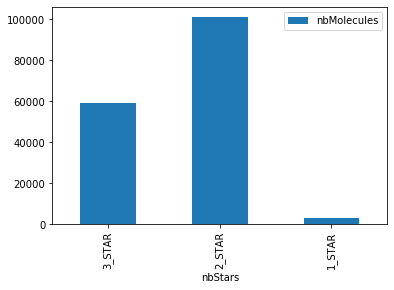

In [23]:
df.plot.bar(x='nbStars', y='nbMolecules')

In [24]:
query="""
SELECT (COUNT(DISTINCT ?molecule) AS ?nbMolecules)
WHERE {
  #VALUES ?molecule { chebidb:32736 }
  
  ?molecule rdfs:subClassOf* chebidb:24431 . # chemical entity
  #?molecule rdfs:subClassOf* chebidb:23367 . # molecular entity

  ?molecule rdf:type owl:Class .
  ?molecule oboInOwl:inSubset ?subset .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df['nbMolecules'] = pandas.to_numeric(df['nbMolecules'])
df

nbMolecules
0       162910

> **Interpretation:** There are 162910 descendants of chemical entity, all of which are either 1_STAR, 2_STAR or 3_STAR